In [201]:
import pandas as pd
import PIL
import openpyxl
from PIL import Image, ImageEnhance
import pytesseract
import numpy as np
import math
from PIL import ImageFilter,ImageDraw
import ast
import os
import google.generativeai as genai
from google import generativeai
from google.generativeai import types
from PIL import Image
import json
import time
import requests
import io

import easyocr
pytesseract.pytesseract.tesseract_cmd =r'C:\Program Files\Tesseract-OCR\tesseract.exe' 
from google.cloud import vision

inputimg='C:\\Users\\juana\\Documents\\FlyCowOCR\\img-input2'

In [202]:
keygooglecloudvision='

In [203]:
from google.cloud import vision
client = vision.ImageAnnotatorClient(client_options={'api_key': keygooglecloudvision})

In [ ]:
apikey=''

In [204]:

def scale_width_and_pad_down(image, target_width=680, target_height=675, color=(255, 255, 255)):
    original_width, original_height = image.size
    if original_width != target_width:
        scale_factor = target_width / original_width
        new_height = int(original_height * scale_factor)
        image = image.resize((target_width, new_height), Image.LANCZOS)
    new_width, new_height = image.size
    if new_height < target_height:
        new_image = Image.new("RGB", (target_width, target_height), color)
        new_image.paste(image, (0, 0))
        return new_image
    else:
        return image

def find_column_boundaries(image, threshold=0.95, min_gap_width=5):
    img_array = np.array(image)
    if len(img_array.shape) == 3:
        img_array = img_array[:, :, 0]

    height, width = img_array.shape
    white_columns = []

    for x in range(width):
        col = img_array[:, x]
        white_ratio = np.mean(col > 240)
        if white_ratio >= threshold:
            white_columns.append(x)

    boundaries = []
    start = None
    for i in range(1, len(white_columns)):
        if white_columns[i] != white_columns[i - 1] + 1:
            if start is not None and white_columns[i - 1] - start >= min_gap_width:
                boundaries.append((start, white_columns[i - 1]))
            start = white_columns[i]
        elif start is None:
            start = white_columns[i - 1]

    if start is not None and white_columns[-1] - start >= min_gap_width:
        boundaries.append((start, white_columns[-1]))

    column_cuts = []
    prev_cut = 0
    for start, end in boundaries:
        cut = (prev_cut, start)
        if cut[1] - cut[0] > 10:
            column_cuts.append(cut)
        prev_cut = end
    column_cuts.append((prev_cut, width))
    return column_cuts
def cortar_por_primera_linea_negra(img, umbral_negro=75, tolerancia_blancos_ratio=0.31, debug=True):

    img_np = np.array(img)

    height, width = img_np.shape
    tolerancia_blancos = int(width * tolerancia_blancos_ratio)

    for y in range(height):
        blancos = np.sum(img_np[y] > umbral_negro)
        if blancos <= tolerancia_blancos:
            if debug:
                print(f"black line search in y = {y} with {blancos} white pixels.")
            cortada = img.crop((0, y, width, height))
            return cortada

    
    return img

In [191]:

e1=[]
e2=[]
e3=[]
e4=[]
e5=[]
e6=[]
e7=[]
e8=[]
e9=[]
e10=[]
rowless_used=[]

In [7]:
genai.configure(api_key=apikey)

In [ ]:
for filename in os.listdir(inputimg):
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")


    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L') 
    openimg = openimg.crop((0, 59, openimg.width, openimg.height)) 

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40)) 
    openimg = enhancer.enhance(2)
    openimg = cortar_por_primera_linea_negra(openimg) 
    imgtpocr = openimg 


    column_boundaries = find_column_boundaries(openimg)
    row_size = 11
    row_less = 0 


    pivotcolum = imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))

    for x in range(1):
        width, height = pivotcolum.size
        n_round = math.floor(height / (row_size))

        for e in range(n_round):
            top = e * row_size
            bottom = top + row_size
            row_pivotcolum = pivotcolum.crop((0, top -2, width, bottom + 2))

    
            byte_stream = io.BytesIO()
            row_pivotcolum.save(byte_stream, format='PNG')
            image_bytes = byte_stream.getvalue()
            gc_vision_image = vision.Image(content=image_bytes)


            try:

                response = client.document_text_detection(image=gc_vision_image)
                keyword = response.full_text_annotation.text.replace('\n', ' ').strip()
                if response.error.message:
                    print(f"Error de API para {filename} (keyword detection): {response.error.message}")
                    keyword = "" 
            except Exception as api_error:
                print(f"Excepción al llamar a la API para {filename} (keyword detection): {api_error}")
              
                time.sleep(10) 
                keyword = ""

            if keyword == 'No Ice':
                print('keyword search in row less ' + str(row_less), keyword)
                rowless_used.append(row_less)

                for i, (x0, x1) in enumerate(column_boundaries):
                    # Lógica de recorte de columnas basada en 'i'
                    if x0 + 10 < x1 and i == 1:
                        col_crop = imgtpocr.crop((x0 - 38, 0, x1 + 15, openimg.height))
                    elif x0 + 10 < x1 and i == 0:
                        col_crop = imgtpocr.crop((x0 - x0, 0, x1 + 30, openimg.height))
                    elif x0 + 10 < x1:
                        col_crop = imgtpocr.crop((x0 - 5, 0, x1 + 15, openimg.height))
                    else: # Si la condición x0 + 10 < x1 no se cumple, maneja este caso
                        print(f"Saltando columna {i} debido a tamaño insuficiente: {x1 - x0}")
                        continue # Salta a la siguiente iteración del bucle 'for i'

                    width, height = col_crop.size
                    
                    row_crop = col_crop.crop((0, top-3, width, bottom + 23))

           
                    byte_stream_col = io.BytesIO()
                    row_crop.save(byte_stream_col, format='PNG')
                    image_bytes_col = byte_stream_col.getvalue()
                    gc_vision_image_col = vision.Image(content=image_bytes_col)

                  
                    try:
                       
                        response_col = client.document_text_detection(image=gc_vision_image_col)
                        text = response_col.full_text_annotation.text.replace('\n', ',').strip()
                        if response_col.error.message:
                            print(f"Error de API para {filename}, col {i}: {response_col.error.message}")
                            text = "" 
                    except Exception as api_error_col:
                        print(f"Excepción al llamar a la API para {filename}, col {i}: {api_error_col}")
                        time.sleep(10) 
                        text = "" 

                
                    if i == 0:
                        e1.append(text)
                    elif i == 1:
                        e2.append(text)
                    elif i == 2:
                        e3.append(text)
                    elif i == 3:
                        e4.append(text)
                    elif i == 4:
                        e5.append(text)
                    elif i == 5:
                        e6.append(text)
                    elif i == 6:
                        e7.append(text)
                    elif i == 7:
                        e8.append(text)
                    elif i == 8:
                        e9.append(text)

                    print('Spin ' + str(x), 'column ' + str(i), 'page ' + str(filename), 'row less: ' + str(row_less), f'Extracted: "{text}"')
    row_less += 3 

Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.
Excepción al llamar a la API para 1b.PNG (keyword detection): 503 WSASend: Connection aborted (An established connection was aborted by the software in your host machine.
 -- 10053)
keyword search in row less 0 No Ice
Spin 0 column 0 page 1b.PNG row less: 0 Extracted: "(2) SBNHH-1D65C w/,Mount Pipe,(Verizon),E"
Spin 0 column 1 page 1b.PNG row less: 0 Extracted: "B,From Leg"
Spin 0 column 2 page 1b.PNG row less: 0 Extracted: "3.00,0.00,0.00"
Spin 0 column 3 page 1b.PNG row less: 0 Extracted: "0.0000"
Spin 0 column 4 page 1b.PNG row less: 0 Extracted: "257.00"
Spin 0 column 5 page 1b.PNG row less: 0 Extracted: "No Ice,1/2" Ice,1" Ice"
Spin 0 column 6 page 1b.PNG row less: 0 Extracted: "11.63,12.35,13.07"
Spin 0 column 7 page 1b.PNG row less: 0 Extracted: "9.79,11.31,12.83"
Spin 0 column 8 page 1b.PNG row less: 0 Extracted: "82.00,172.00,262.00"
Saltando columna 9 debido a tamaño insuficiente: 1
keyword search in row les

In [ ]:
for filename in os.listdir(inputimg)[:1]:
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")


    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L') 
    openimg = openimg.crop((0, 59, openimg.width, openimg.height)) 

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40)) 
    openimg = enhancer.enhance(2)
    openimg = cortar_por_primera_linea_negra(openimg) 
    imgtpocr = openimg 


    column_boundaries = find_column_boundaries(openimg)
    row_size = 11
    row_less = 0 


    pivotcolum = imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))

    for x in range(1):
        width, height = pivotcolum.size
        n_round = math.floor(height / (row_size))

        for e in range(n_round):
            top = e * row_size
            bottom = top + row_size
            row_pivotcolum = pivotcolum.crop((0, top -2, width, bottom + 2))

    
            # byte_stream = io.BytesIO()
            # row_pivotcolum.save(byte_stream, format='PNG')
            # image_bytes = byte_stream.getvalue()
            # gc_vision_image = vision.Image(content=image_bytes)




            # response = client.document_text_detection(image=gc_vision_image)
            # keyword = response.full_text_annotation.text.replace('\n', ' ').strip()
    

                
    row_less += 3 

Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.


In [285]:
row_pivotcolum

In [271]:
row_pivotcolum.size

(53, 11)

In [124]:



# ...

for filename in os.listdir(inputimg):
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40))
    openimg = enhancer.enhance(2)
    openimg = cortar_por_primera_linea_negra(openimg)
    imgtpocr = openimg

    column_boundaries = find_column_boundaries(openimg)
    row_size = 13
    row_less = 0
    pivotcolum = imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))

    for x in range(1):
        width, height = pivotcolum.size
        n_round = math.floor(height / (row_size - 1.5))  
        for e in range(n_round)[:1]:
            top = e * row_size
            bottom = top + row_size
            row_pivotcolum = pivotcolum.crop((0, top + row_less, width, bottom + row_less))
            resized_crop=row_pivotcolum.resize((row_pivotcolum.width * 10, row_pivotcolum.height * 10), Image.LANCZOS)
        #     while True:
        #         try:
        #             model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
        #             response = model.generate_content(
        #                 [row_pivotcolum, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
        #             )
        #             break
        #         except ResourceExhausted:
        #             time.sleep(40)
        #     keyword = response.text.replace('\n', ' ').strip()
        #     if keyword == 'No Ice':
                    
        #         print('keyword search in row less ' + str(row_less), keyword)
        #         rowless_used.append(row_less)
        #         for i, (x0, x1) in enumerate(column_boundaries):
        #             if x0 + 10 < x1 and i == 1:
        #                 col_crop = imgtpocr.crop((x0 - 38, 0, x1 + 15, openimg.height))
        #             elif x0 + 10 < x1 and i == 0:
        #                 col_crop = imgtpocr.crop((x0 - x0, 0, x1 + 30, openimg.height))
        #             elif x0 + 10 < x1:
        #                 col_crop = imgtpocr.crop((x0 - 5, 0, x1 + 15, openimg.height))
        #             width, height = col_crop.size
        #             row_crop = col_crop.crop((0, top, width, bottom+23)) 

        #             while True:
        #                 try:
        #                     model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
        #                     response = model.generate_content(
        #                         [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
        #                     )
        #                     break
        #                 except ResourceExhausted:
        #                     time.sleep(40)

        #             text = response.text.replace('\n', ',')
        #             if i == 0:
        #                 e1.append(text)
        #             elif i == 1:
        #                 e2.append(text)
        #             elif i == 2:
        #                 e3.append(text)
        #             elif i == 3:
        #                 e4.append(text)
        #             elif i == 4:
        #                 e5.append(text)
        #             elif i == 5:
        #                 e6.append(text)
        #             elif i == 6:
        #                 e7.append(text)
        #             elif i == 7:
        #                 e8.append(text)
        #             elif i == 8:
        #                 e9.append(text)

        #             print('Spin ' + str(x), 'column ' + str(i), 'page ' + str(filename), 'row less: ' + str(row_less))
        # row_less += 3

Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.
Procesando: 2a.PNG
black line search in y = 42 with 15 white pixels.
Procesando: 2b.PNG
black line search in y = 42 with 16 white pixels.
Procesando: 2c.PNG
black line search in y = 43 with 13 white pixels.
Procesando: 3a.PNG
black line search in y = 37 with 23 white pixels.
Procesando: 3b.PNG
black line search in y = 33 with 17 white pixels.
Procesando: 4a.PNG
black line search in y = 34 with 12 white pixels.
Procesando: 4b.PNG
black line search in y = 34 with 15 white pixels.
Procesando: 5a.PNG
black line search in y = 40 with 12 white pixels.
Procesando: 5b.PNG
black line search in y = 40 with 21 white pixels.
Procesando: 5c.PNG
black line search in y = 41 with 23 white pixels.
Procesando: DAs.PNG
black line search in y = 36 with 12 white pixels.


In [128]:
image_array = np.array(resized_crop)

In [129]:
image = vision.Image(content=image_array)

TypeError: expected bytes, numpy.ndarray found

In [39]:
import time
from google.api_core.exceptions import ResourceExhausted

# ...

for filename in os.listdir(inputimg):
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40))
    openimg = enhancer.enhance(2)
    openimg = cortar_por_primera_linea_negra(openimg)
    imgtpocr = openimg

    column_boundaries = find_column_boundaries(openimg)
    row_size = 13
    row_less = 0
    pivotcolum = imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))

    for x in range(1):
        width, height = pivotcolum.size
        n_round = math.floor(height / (row_size - 1.5))  
        for e in range(n_round):
            top = e * row_size
            bottom = top + row_size
            row_pivotcolum = pivotcolum.crop((0, top + row_less, width, bottom + row_less))
            while True:
                try:
                    model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                    response = model.generate_content(
                        [row_pivotcolum, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                    )
                    break
                except ResourceExhausted:
                    time.sleep(40)
            keyword = response.text.replace('\n', ' ').strip()
            if keyword == 'No Ice':
                    
                print('keyword search in row less ' + str(row_less), keyword)
                rowless_used.append(row_less)
                for i, (x0, x1) in enumerate(column_boundaries):
                    if x0 + 10 < x1 and i == 1:
                        col_crop = imgtpocr.crop((x0 - 38, 0, x1 + 15, openimg.height))
                    elif x0 + 10 < x1 and i == 0:
                        col_crop = imgtpocr.crop((x0 - x0, 0, x1 + 30, openimg.height))
                    elif x0 + 10 < x1:
                        col_crop = imgtpocr.crop((x0 - 5, 0, x1 + 15, openimg.height))
                    width, height = col_crop.size
                    row_crop = col_crop.crop((0, top, width, bottom+23)) 

                    while True:
                        try:
                            model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                            response = model.generate_content(
                                [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                            )
                            break
                        except ResourceExhausted:
                            time.sleep(40)

                    text = response.text.replace('\n', ',')
                    if i == 0:
                        e1.append(text)
                    elif i == 1:
                        e2.append(text)
                    elif i == 2:
                        e3.append(text)
                    elif i == 3:
                        e4.append(text)
                    elif i == 4:
                        e5.append(text)
                    elif i == 5:
                        e6.append(text)
                    elif i == 6:
                        e7.append(text)
                    elif i == 7:
                        e8.append(text)
                    elif i == 8:
                        e9.append(text)

                    print('Spin ' + str(x), 'column ' + str(i), 'page ' + str(filename), 'row less: ' + str(row_less))
        row_less += 3


Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.


DefaultCredentialsError: 
  No API_KEY or ADC found. Please either:
    - Set the `GOOGLE_API_KEY` environment variable.
    - Manually pass the key with `genai.configure(api_key=my_api_key)`.
    - Or set up Application Default Credentials, see https://ai.google.dev/gemini-api/docs/oauth for more information.

EASYOCR


In [102]:
reader = easyocr.Reader(['en']) 
import cv2

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [119]:
for filename in os.listdir(inputimg):
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    openimg = Image.open(filepath)
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
    # openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40))
    openimg=openimg.filter(ImageFilter.MedianFilter(size=3))
    openimg = enhancer.enhance(2)
    openimg = cortar_por_primera_linea_negra(openimg)
    imgtpocr = openimg

    column_boundaries = find_column_boundaries(openimg)
    row_size = 13
    row_less = 0
    pivotcolum = imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))

    for x in range(1):
        width, height = pivotcolum.size
        n_round = math.floor(height / (row_size - 1.5))  
        for e in range(n_round):
            top = e * row_size
            bottom = top + row_size
            row_pivotcolum = pivotcolum.crop((0, top + row_less, width, bottom + row_less))
            resized_crop=row_pivotcolum.resize((row_pivotcolum.width * 10, row_pivotcolum.height * 10), Image.LANCZOS)
            image_array = np.array(resized_crop)
            # _, image_array = cv2.threshold(image_array, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
            dist=cv2.distanceTransform(image_array,cv2.DIST_L2,5)
            dist=cv2.normalize(dist,dist,0,1.0,cv2.NORM_MINMAX)
            dist=(dist*255).astype('uint8')
            
            results = reader.readtext(image_array, detail=0)
            keyword=','.join([r for r in results if r.strip() != ''])
            
            if keyword in ['No Ice','No Kce']:
                    
                print('keyword search in row less ' + str(row_less), keyword)
                rowless_used.append(row_less)
                for i, (x0, x1) in enumerate(column_boundaries):
                    if x0 + 10 < x1 and i == 1:
                        col_crop = imgtpocr.crop((x0 - 38, 0, x1 + 15, openimg.height))
                    elif x0 + 10 < x1 and i == 0:
                        col_crop = imgtpocr.crop((x0 - x0, 0, x1 + 27, openimg.height))
                    elif x0 + 10 < x1:
                        col_crop = imgtpocr.crop((x0 - 5, 0, x1 + 15, openimg.height))
                    width, height = col_crop.size
                    row_crop = col_crop.crop((0, top, width, bottom+23)) 

            
             
                    resized_crop=row_crop.resize((row_crop.width * 10, row_crop.height * 10), Image.LANCZOS)
                    if i in [0,1,5]:
                       image_array = np.array(resized_crop)
                       # _, image_array = cv2.threshold(image_array, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
                       dist=cv2.distanceTransform(image_array,cv2.DIST_L2,5)
                       dist=cv2.normalize(dist,dist,0,1.0,cv2.NORM_MINMAX)
                       dist=(dist*255).astype('uint8')  
                       results = reader.readtext(image_array, detail=0)
                       text=','.join([r for r in results if r.strip() != ''])
                    else:
                        text=pytesseract.image_to_string(resized_crop, config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
                    if i == 0:
                        e1.append(text)
                    elif i == 1:
                        e2.append(text)
                    elif i == 2: #num
                        e3.append(text)
                    elif i == 3: #num
                        e4.append(text)
                    elif i == 4: #num
                        e5.append(text)
                    elif i == 5:
                        e6.append(text)
                    elif i == 6: #num
                        e7.append(text)
                    elif i == 7: #num
                        e8.append(text)
                    elif i == 8: #num
                        e9.append(text)
                    print('Spin ' + str(x), 'column ' + str(i), 'page ' + str(filename), 'row less: ' + str(row_less))
            else:
              print(keyword)
        row_less += 3


Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.


c:\Users\juana\Documents\FlyCowOCRD\ocr_flycow\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


keyword search in row less 0 No Kce
Spin 0 column 0 page 1b.PNG row less: 0


KeyboardInterrupt: 

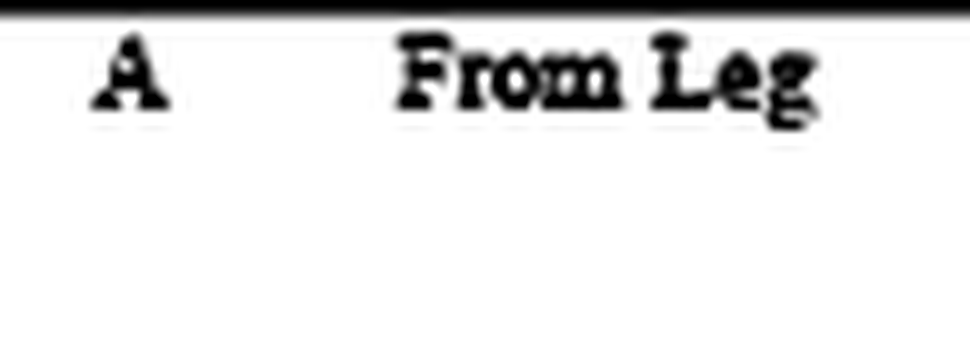

In [120]:
resized_crop

In [95]:
image_array = np.array(resized_crop)

In [100]:

dist=cv2.distanceTransform(image_array,cv2.DIST_L2,5)
dist=cv2.normalize(dist,dist,0,1.0,cv2.NORM_MINMAX)
dist=(dist*255).astype('uint8')  
results = reader.readtext(image_array, detail=0)
text=','.join([r for r in results if r.strip() != ''])

c:\Users\juana\Documents\FlyCowOCRD\ocr_flycow\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [101]:
text

'No Kce'

In [70]:
keyword=pytesseract.image_to_string(resized_crop.filter(ImageFilter.MedianFilter(size=9)), config=r'--psm 7 --oem 3 -l eng -c tessedit_char_whitelist=No Ice').strip().replace('\n',',')   

In [71]:
keyword

'No'

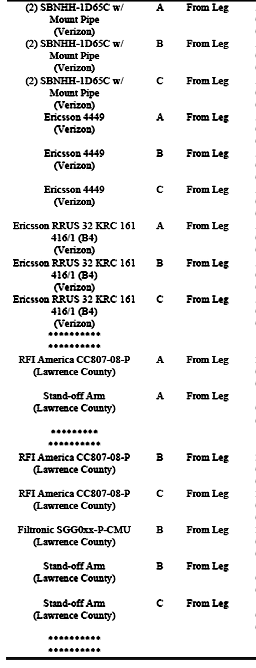

In [48]:
imgtpocr.crop((x0 - x0, 0, x1 + 27, openimg.height))

In [16]:
row_pivotcolum.resize((row_crop.width * 10, row_crop.height * 10), Image.LANCZOS)

NameError: name 'row_crop' is not defined

In [268]:
math.floor(height / (row_size - 1.5)) 

58

In [267]:
rowless_used

[0, 0, 0, 0, 0, 0, 0, 0, 0]

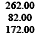

In [259]:
col_crop.crop((0, top, width, bottom+23)) 

In [45]:
listpivot=['Noe,1/2"Ice,1"Ice','No Ice,1/2"Ice,1"Ice','NoIe,1/2"Ice,1"Ice','NoIce,1/2"Ice,1"Ice','1"Ice,Noe,/2"Ice','1"Ice,Noe,1/2"Ice','1"Ice,Noe,1/"Ice','1"Ice,NoIce,1/2"Ice','1"Ice,NoIce,/2"Ice']
for filename in os.listdir(inputimg):
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    # openimg = Image.open(filepath).convert('RGB')
    # openimg = scale_width_and_pad_down(openimg)
    # openimg = openimg.convert('L')
    # openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    # enhancer = ImageEnhance.Contrast(openimg)
    # openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    # openimg = enhancer.enhance(2)
    # openimg=cortar_por_primera_linea_negra(openimg)
    # openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.01))
    # openimg=openimg.filter(ImageFilter.MedianFilter(size=1))
    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40))
# openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    # openimg=openimg.filter(ImageFilter.MedianFilter(size=3))
    openimg=openimg.filter(ImageFilter.MedianFilter(size=3))
    openimg = enhancer.enhance(2)
    openimg=cortar_por_primera_linea_negra(openimg)
    imgtpocr=openimg




    column_boundaries = find_column_boundaries(openimg)
    row_size=38
    row_less=-3
    pivotcolum=imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))
    for x in range(16):
         width, height = pivotcolum.size
         n_round=math.floor(height/(row_size-2))  
         for e in range(n_round):
             top = e * row_size
             bottom = top + row_size
             row_pivotcolum = pivotcolum.crop((0, top+row_less, width, bottom+row_less))
             keyword=pytesseract.image_to_string(row_pivotcolum.resize((row_pivotcolum.width * 8, row_pivotcolum.height * 8), Image.LANCZOS), config = r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=No1/2"eIc,').strip().replace('\n',',') 
             if keyword in listpivot:
                  print('keyword search in row less '+ str(row_less))
                  rowless_used.append(row_less)
                  for i, (x0, x1) in enumerate(column_boundaries):
                    if x0+10 < x1 and i==1:
                     col_crop = imgtpocr.crop((x0-38, 0, x1+15, openimg.height))
                    elif x0+10 < x1 and i==0:
                      col_crop = imgtpocr.crop((x0-x0, 0, x1+30, openimg.height))
                    elif x0+10 < x1:
                     col_crop = imgtpocr.crop((x0-5, 0, x1+15, openimg.height))
                    width, height = col_crop.size
                    
                    row_crop = col_crop.crop((0, top+row_less, width, bottom+row_less)) 
                    if i==0:
                       element1 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 10, row_crop.height * 10), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng').strip().replace('\n',',')
                       e1.append(element1)
                    elif i==1:
                        element2 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=ABCDFromLegNn ').strip()
                        e2.append(element2)   
                    elif i==2:
                        element3 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',')  
                        e3.append(element3)   
                    elif i==3:
                        element4 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 7 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
                        e4.append(element4)      
                    elif i==4:
                        element5 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 7 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
                        e5.append(element5)      
                    elif i==5:
                        element6 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS), config = r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=No1/2"eIc,').strip().replace('\n',',')    
                        e6.append(element6)   
                    elif i==6:
                        element7 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
                        e7.append(element7)      
                    elif i==7: 
                        element8 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
                        e8.append(element8)   
                    elif i==8:           
                        element9 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
                        e9.append(element9) 
                    print('Spin '+ str(x), 'column '+ str(i), 'page '+ str(filename), 'row less: '+ str(row_less))

         row_less+=1  
    

Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.
keyword search in row less -3
Spin 0 column 0 page 1b.PNG row less: -3
Spin 0 column 1 page 1b.PNG row less: -3
Spin 0 column 2 page 1b.PNG row less: -3
Spin 0 column 3 page 1b.PNG row less: -3
Spin 0 column 4 page 1b.PNG row less: -3
Spin 0 column 5 page 1b.PNG row less: -3
Spin 0 column 6 page 1b.PNG row less: -3
Spin 0 column 7 page 1b.PNG row less: -3
Spin 0 column 8 page 1b.PNG row less: -3
Spin 0 column 9 page 1b.PNG row less: -3
keyword search in row less -3
Spin 0 column 0 page 1b.PNG row less: -3
Spin 0 column 1 page 1b.PNG row less: -3
Spin 0 column 2 page 1b.PNG row less: -3
Spin 0 column 3 page 1b.PNG row less: -3
Spin 0 column 4 page 1b.PNG row less: -3
Spin 0 column 5 page 1b.PNG row less: -3
Spin 0 column 6 page 1b.PNG row less: -3
Spin 0 column 7 page 1b.PNG row less: -3
Spin 0 column 8 page 1b.PNG row less: -3
Spin 0 column 9 page 1b.PNG row less: -3
keyword search in row less -3
Spin 0 column 0 page 

KeyboardInterrupt: 

easy OCR

In [ ]:
reader = easyocr.Reader(['en']) 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [ ]:

listpivot=['Noe,1/2"Ice,1"Ice','No Ice,1/2"Ice,1"Ice','NoIe,1/2"Ice,1"Ice','NoIce,1/2"Ice,1"Ice','1"Ice,Noe,/2"Ice','1"Ice,Noe,1/2"Ice','1"Ice,Noe,1/"Ice','1"Ice,NoIce,1/2"Ice','1"Ice,NoIce,/2"Ice']
for filename in os.listdir(inputimg)[:1]:
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    # openimg = Image.open(filepath).convert('RGB')
    # openimg = scale_width_and_pad_down(openimg)
    # openimg = openimg.convert('L')
    # openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    # enhancer = ImageEnhance.Contrast(openimg)
    # openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    # openimg = enhancer.enhance(2)
    # openimg=cortar_por_primera_linea_negra(openimg)
    # openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.01))
    # openimg=openimg.filter(ImageFilter.MedianFilter(size=1))
    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
   #  openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40))
# openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    openimg=openimg.filter(ImageFilter.MedianFilter(size=3))
    openimg = enhancer.enhance(2)
    openimg=cortar_por_primera_linea_negra(openimg)
    imgtpocr=openimg




    column_boundaries = find_column_boundaries(openimg)
    row_size=38
    row_less=-3
    pivotcolum=imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))
    for x in range(9):
         width, height = pivotcolum.size
         n_round=math.floor(height/(row_size-2))  
         for e in range(n_round):
             top = e * row_size
             bottom = top + row_size
             row_pivotcolum = pivotcolum.crop((0, top+row_less, width, bottom+row_less))
             keyword=pytesseract.image_to_string(row_pivotcolum.resize((row_pivotcolum.width * 8, row_pivotcolum.height * 8), Image.LANCZOS), config = r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=No1/2"eIc,').strip().replace('\n',',') 
             if keyword in listpivot:
                  print('keyword search in row less '+ str(row_less))
                  rowless_used.append(row_less)
                  for i, (x0, x1) in enumerate(column_boundaries):
                    if x0+10 < x1 and i==1:
                     col_crop = imgtpocr.crop((x0-38, 0, x1+15, openimg.height))
                    elif x0+10 < x1 and i==0:
                      col_crop = imgtpocr.crop((x0-x0, 0, x1+30, openimg.height))
                    elif x0+10 < x1:
                     col_crop = imgtpocr.crop((x0-5, 0, x1+15, openimg.height))
                    width, height = col_crop.size
                    
                    row_crop = col_crop.crop((0, top+row_less, width, bottom+row_less)) 
                    if i==0:
                       resized_crop=row_crop.resize((row_crop.width * 10, row_crop.height * 10), Image.LANCZOS)
                       image_array = np.array(resized_crop)
                       results = reader.readtext(image_array, detail=0)
                       element1=','.join([r for r in results if r.strip() != ''])
                       e1.append(element1)
                    elif i==1:
                       resized_crop=row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS)
                       image_array = np.array(resized_crop)
                       results = reader.readtext(image_array, detail=0)
                       element2=','.join([r for r in results if r.strip() != ''])
                       e2.append(element2)   
                    elif i==2:
                       resized_crop=row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS)
                       image_array = np.array(resized_crop)
                       results = reader.readtext(image_array, detail=0)
                       element3=','.join([r for r in results if r.strip() != ''])
                       e3.append(element3)   
                    elif i==3:
                       resized_crop=row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS)
                       image_array = np.array(resized_crop)
                       results = reader.readtext(image_array, detail=0)
                       element4=','.join([r for r in results if r.strip() != ''])
                       e4.append(element4)      
                    elif i==4:
                       resized_crop=row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS)
                       image_array = np.array(resized_crop)
                       results = reader.readtext(image_array, detail=0)
                       element5=','.join([r for r in results if r.strip() != ''])
                       e5.append(element5)      
                    elif i==5:
                       resized_crop=row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS)
                       image_array = np.array(resized_crop)
                       results = reader.readtext(image_array, detail=0)
                       element6=','.join([r for r in results if r.strip() != ''])    
                       e6.append(element6)   
                    elif i==6:
                       resized_crop=row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS)
                       image_array = np.array(resized_crop)
                       results = reader.readtext(image_array, detail=0)
                       element7=','.join([r for r in results if r.strip() != ''])     
                       e7.append(element7)      
                    elif i==7:
                       resized_crop=row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS)
                       image_array = np.array(resized_crop)
                       results = reader.readtext(image_array, detail=0)
                       element8=','.join([r for r in results if r.strip() != ''])    
                       e8.append(element8)   
                    elif i==8:
                       resized_crop=row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS)
                       image_array = np.array(resized_crop)
                       results = reader.readtext(image_array, detail=0)
                       element9=','.join([r for r in results if r.strip() != ''])               
                       e9.append(element9) 
                    print('Spin '+ str(x), 'column '+ str(i), 'page '+ str(filename), 'row less: '+ str(row_less))

         row_less+=1  
    

Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.
keyword search in row less -3
Spin 0 column 0 page 1b.PNG row less: -3
Spin 0 column 1 page 1b.PNG row less: -3
Spin 0 column 2 page 1b.PNG row less: -3
Spin 0 column 3 page 1b.PNG row less: -3
Spin 0 column 4 page 1b.PNG row less: -3
Spin 0 column 5 page 1b.PNG row less: -3
Spin 0 column 6 page 1b.PNG row less: -3
Spin 0 column 7 page 1b.PNG row less: -3
Spin 0 column 8 page 1b.PNG row less: -3
Spin 0 column 9 page 1b.PNG row less: -3
keyword search in row less -3
Spin 0 column 0 page 1b.PNG row less: -3
Spin 0 column 1 page 1b.PNG row less: -3
Spin 0 column 2 page 1b.PNG row less: -3
Spin 0 column 3 page 1b.PNG row less: -3
Spin 0 column 4 page 1b.PNG row less: -3
Spin 0 column 5 page 1b.PNG row less: -3
Spin 0 column 6 page 1b.PNG row less: -3
Spin 0 column 7 page 1b.PNG row less: -3
Spin 0 column 8 page 1b.PNG row less: -3
Spin 0 column 9 page 1b.PNG row less: -3
keyword search in row less -3
Spin 0 column 0 page 

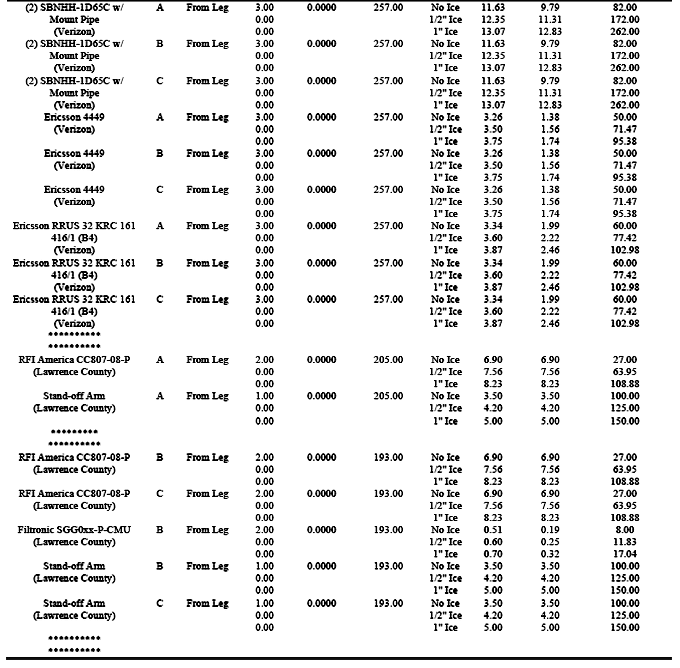

In [ ]:
imgtpocr

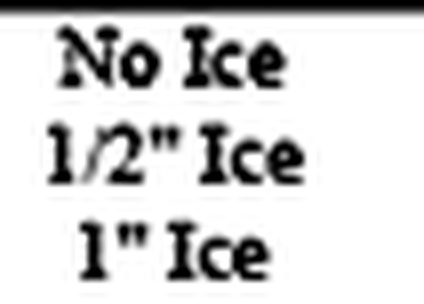

In [ ]:
row_pivotcolum.resize((row_pivotcolum.width * 8, row_pivotcolum.height * 8), Image.LANCZOS)

In [ ]:
image_array = np.array(row_pivotcolum.resize((row_pivotcolum.width * 2, row_pivotcolum.height * 2), Image.LANCZOS))
results = reader.readtext(image_array, detail=0)
','.join([r for r in results if r.strip() != ''])

'No Kce,1n" Ice,1" Ice'

In [ ]:
keyword

'Noe,1/2"Ice,1"Ice'

In [ ]:
resized_crop = row_crop.resize((row_crop.width * 10, row_crop.height * 10), Image.LANCZOS)

# Convertir imagen PIL a numpy array (EasyOCR trabaja con arrays)
image_array = np.array(resized_crop)

# Ejecutar OCR
results = reader.readtext(image_array, detail=0)

# Unir los resultados en una sola cadena (como lo hacías con replace('\n', ','))
','.join([r for r in results if r.strip() != ''])


c:\Users\juana\Documents\FlyCowOCRD\ocr_flycow\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


'(2) SBNHH-ID6sc,Mount,(Verizon),R,pipe'

In [ ]:
keyword

''

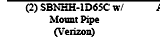

In [ ]:
row_crop

In [ ]:
import time
from google.api_core.exceptions import ResourceExhausted

# ...

for filename in os.listdir(inputimg)[:1]:
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40))
    openimg = enhancer.enhance(2)
    openimg = cortar_por_primera_linea_negra(openimg)
    imgtpocr = openimg

    column_boundaries = find_column_boundaries(openimg)
    row_size = 40
    row_less = 0
    pivotcolum = imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))

    for x in range(2):
        width, height = pivotcolum.size
        n_round = math.floor(height / (row_size - 4))  
        for e in range(n_round):
            top = e * row_size
            bottom = top + row_size
            row_pivotcolum = pivotcolum.crop((0, top + row_less, width, bottom + row_less))
            while True:
                try:
                    model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                    response = model.generate_content(
                        [row_pivotcolum, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                    )
                    break
                except ResourceExhausted:
                    time.sleep(40)
            keyword = response.text.replace('\n', ' ')
            if keyword == 'No Ice 1/2" Ice 1" Ice':
                print('keyword search in row less ' + str(row_less), keyword)
                rowless_used.append(row_less)
                for i, (x0, x1) in enumerate(column_boundaries):
                    if x0 + 10 < x1 and i == 1:
                        col_crop = imgtpocr.crop((x0 - 38, 0, x1 + 15, openimg.height))
                    elif x0 + 10 < x1 and i == 0:
                        col_crop = imgtpocr.crop((x0 - x0, 0, x1 + 30, openimg.height))
                    elif x0 + 10 < x1:
                        col_crop = imgtpocr.crop((x0 - 5, 0, x1 + 15, openimg.height))
                    width, height = col_crop.size
                    row_crop = col_crop.crop((0, top + row_less, width, bottom + row_less)) 

        #             while True:
        #                 try:
        #                     model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
        #                     response = model.generate_content(
        #                         [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
        #                     )
        #                     break
        #                 except ResourceExhausted:
        #                     time.sleep(40)

        #             text = response.text.replace('\n', ',')
        #             if i == 0:
        #                 e1.append(text)
        #             elif i == 1:
        #                 e2.append(text)
        #             elif i == 2:
        #                 e3.append(text)
        #             elif i == 3:
        #                 e4.append(text)
        #             elif i == 4:
        #                 e5.append(text)
        #             elif i == 5:
        #                 e6.append(text)
        #             elif i == 6:
        #                 e7.append(text)
        #             elif i == 7:
        #                 e8.append(text)
        #             elif i == 8:
        #                 e9.append(text)

        #             print('Spin ' + str(x), 'column ' + str(i), 'page ' + str(filename), 'row less: ' + str(row_less))
        # row_less += 3


Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.
keyword search in row less 0 No Ice 1/2" Ice 1" Ice
Spin 0 column 0 page 1b.PNG row less: 0
Spin 0 column 1 page 1b.PNG row less: 0
Spin 0 column 2 page 1b.PNG row less: 0
Spin 0 column 3 page 1b.PNG row less: 0
Spin 0 column 4 page 1b.PNG row less: 0
Spin 0 column 5 page 1b.PNG row less: 0
Spin 0 column 6 page 1b.PNG row less: 0
Spin 0 column 7 page 1b.PNG row less: 0
Spin 0 column 8 page 1b.PNG row less: 0
Spin 0 column 9 page 1b.PNG row less: 0
keyword search in row less 0 No Ice 1/2" Ice 1" Ice
Spin 0 column 0 page 1b.PNG row less: 0
Spin 0 column 1 page 1b.PNG row less: 0
Spin 0 column 2 page 1b.PNG row less: 0
Spin 0 column 3 page 1b.PNG row less: 0
Spin 0 column 4 page 1b.PNG row less: 0
Spin 0 column 5 page 1b.PNG row less: 0
Spin 0 column 6 page 1b.PNG row less: 0
Spin 0 column 7 page 1b.PNG row less: 0
Spin 0 column 8 page 1b.PNG row less: 0
Spin 0 column 9 page 1b.PNG row less: 0
keyword search in row less 

In [ ]:
listpivot=['Noe,1/2"Ice,1"Ice','No Ice,1/2"Ice,1"Ice','NoIe,1/2"Ice,1"Ice','NoIce,1/2"Ice,1"Ice','1"Ice,Noe,/2"Ice','1"Ice,Noe,1/2"Ice','1"Ice,Noe,1/"Ice','1"Ice,NoIce,1/2"Ice','1"Ice,NoIce,/2"Ice']
for filename in os.listdir(inputimg)[:1]:
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    # openimg = Image.open(filepath).convert('RGB')
    # openimg = scale_width_and_pad_down(openimg)
    # openimg = openimg.convert('L')
    # openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    # enhancer = ImageEnhance.Contrast(openimg)
    # openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    # openimg = enhancer.enhance(2)
    # openimg=cortar_por_primera_linea_negra(openimg)
    # openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.01))
    # openimg=openimg.filter(ImageFilter.MedianFilter(size=1))
    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40))
# openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    # openimg=openimg.filter(ImageFilter.MedianFilter(size=3))
    openimg = enhancer.enhance(2)
    openimg=cortar_por_primera_linea_negra(openimg)
    imgtpocr=openimg




    column_boundaries = find_column_boundaries(openimg)
    row_size=40
    row_less=0
    pivotcolum=imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))
    for x in range(3):
         width, height = pivotcolum.size
         n_round=math.floor(height/(row_size-4))  
         for e in range(n_round):
             top = e * row_size
             bottom = top + row_size
             row_pivotcolum = pivotcolum.crop((0, top+row_less, width, bottom+row_less))
             model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
             response = model.generate_content(
             [row_pivotcolum, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"])
             keyword=response.text.replace('\n',' ')
             if keyword=='No Ice 1/2" Ice 1" Ice':
                  print('keyword search in row less '+ str(row_less),keyword)
                  rowless_used.append(row_less)
                  for i, (x0, x1) in enumerate(column_boundaries):
                    if x0+10 < x1 and i==1:
                     col_crop = imgtpocr.crop((x0-38, 0, x1+15, openimg.height))
                    elif x0+10 < x1 and i==0:
                      col_crop = imgtpocr.crop((x0-x0, 0, x1+30, openimg.height))
                    elif x0+10 < x1:
                     col_crop = imgtpocr.crop((x0-5, 0, x1+15, openimg.height))
                    width, height = col_crop.size
                    
                    row_crop = col_crop.crop((0, top+row_less, width, bottom+row_less)) 
                    if i==0:
                       model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                       response = model.generate_content(
                             [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"])
                       element1 = response.text.replace('\n',',')
                       e1.append(element1)
                    elif i==1:
                        model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                        response = model.generate_content(
                             [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"])
                        element2 = response.text.replace('\n',',')
                        e2.append(element2)   
                    elif i==2:
                        model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                        response = model.generate_content(
                             [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                         )
                        element3 = response.text.replace('\n',',')
                        e3.append(element3)   
                    elif i==3:
                        model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                        response = model.generate_content(
                             [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                         )
                        element4 = response.text.replace('\n',',')
                        e4.append(element4)      
                    elif i==4:
                        model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                        response = model.generate_content(
                             [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                         )
                        element5 = response.text.replace('\n',',')
                        e5.append(element5)      
                    elif i==5:
                        model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                        response = model.generate_content(
                             [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                         )
                        element6 =  response.text.replace('\n',',')    
                        e6.append(element6)   
                    elif i==6:
                        model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                        response = model.generate_content(
                             [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                         )
                        
                        element7 = response.text.replace('\n',',')
                        e7.append(element7)      
                    elif i==7:
                        model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                        response = model.generate_content(
                             [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                         )
                        element8 = response.text.replace('\n',',')
                        e8.append(element8)   
                    elif i==8:
                        model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                        response = model.generate_content(
                             [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
                         )          
                        element9 = response.text.replace('\n',',')
                        e9.append(element9) 
                    print('Spin '+ str(x), 'column '+ str(i), 'page '+ str(filename), 'row less: '+ str(row_less))

         row_less+=3  
    

Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.
keyword search in row less -3 No Ice 1/2" Ice 1" Ice
Spin 0 column 0 page 1b.PNG row less: -3
Spin 0 column 1 page 1b.PNG row less: -3
Spin 0 column 2 page 1b.PNG row less: -3
Spin 0 column 3 page 1b.PNG row less: -3
Spin 0 column 4 page 1b.PNG row less: -3
Spin 0 column 5 page 1b.PNG row less: -3
Spin 0 column 6 page 1b.PNG row less: -3
Spin 0 column 7 page 1b.PNG row less: -3
Spin 0 column 8 page 1b.PNG row less: -3
Spin 0 column 9 page 1b.PNG row less: -3
keyword search in row less -3 No Ice 1/2" Ice 1" Ice
Spin 0 column 0 page 1b.PNG row less: -3
Spin 0 column 1 page 1b.PNG row less: -3
Spin 0 column 2 page 1b.PNG row less: -3
Spin 0 column 3 page 1b.PNG row less: -3
Spin 0 column 4 page 1b.PNG row less: -3
Spin 0 column 5 page 1b.PNG row less: -3
Spin 0 column 6 page 1b.PNG row less: -3
Spin 0 column 7 page 1b.PNG row less: -3
Spin 0 column 8 page 1b.PNG row less: -3
Spin 0 column 9 page 1b.PNG row less: -3
keywo

ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 43
}
]

In [ ]:
listpivot=['Noe,1/2"Ice,1"Ice','No Ice,1/2"Ice,1"Ice','NoIe,1/2"Ice,1"Ice','NoIce,1/2"Ice,1"Ice','1"Ice,Noe,/2"Ice','1"Ice,Noe,1/2"Ice','1"Ice,Noe,1/"Ice','1"Ice,NoIce,1/2"Ice','1"Ice,NoIce,/2"Ice']
for filename in os.listdir(inputimg)[:1]:
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    # openimg = Image.open(filepath).convert('RGB')
    # openimg = scale_width_and_pad_down(openimg)
    # openimg = openimg.convert('L')
    # openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    # enhancer = ImageEnhance.Contrast(openimg)
    # openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    # openimg = enhancer.enhance(2)
    # openimg=cortar_por_primera_linea_negra(openimg)
    # openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.01))
    # openimg=openimg.filter(ImageFilter.MedianFilter(size=1))
    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40))
# openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    # openimg=openimg.filter(ImageFilter.MedianFilter(size=3))
    openimg = enhancer.enhance(2)
    openimg=cortar_por_primera_linea_negra(openimg)
    imgtpocr=openimg




    column_boundaries = find_column_boundaries(openimg)
    row_size=38
    row_less=-3
    pivotcolum=imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))
    for x in range(3):
         width, height = pivotcolum.size
         n_round=math.floor(height/(row_size-2))  
         for e in range(n_round):
             top = e * row_size
             bottom = top + row_size
             row_pivotcolum = pivotcolum.crop((0, top+row_less, width, bottom+row_less))
             model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
             response = model.generate_content(
             [row_pivotcolum, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"])
             keyword=response.text.replace('\n',' ')
             if keyword=='No Ice 1/2" Ice 1" Ice':
                  print('keyword search in row less '+ str(row_less),keyword)
                  rowless_used.append(row_less)
                      
         row_less+=3  
    

In [ ]:
keyword

'ee,Noe,1/2"Ice,1"Ice'

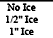

In [ ]:
row_pivotcolum

In [ ]:
model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")

# Haz la solicitud para extraer el texto
response = model.generate_content(
    [row_pivotcolum, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"]
)

In [ ]:
response.text.replace('\n',' ')

'No Ice 1/2" Ice 1" Ice'

In [190]:
allrow=[]
PROMPT_EXTRACCION_FILA = """
Extract all text and numbers from this image.
The image contains a single tabular data entry. I need you to identify and extract the content of 10 distinct vertical columns, processing from left to right.

For each of the 10 columns:
1. Identify the "vertical space" occupied by that column.
2. Collect *all* text and numbers within that visual space, regardless of whether the text spans one or more lines within the column.
3. Preserve internal line breaks and spacing (such as indentation) within the extracted text of each column.
4. If a column is visually empty, return it as an empty string.

Separate the content of each extracted column using a triple pipe delimiter '|||'.
Responds only with the formatted text string (the contents of the 10 columns separated by '|||'), without any additional text, headers, or explanations.
"""


In [ ]:
from google.api_core.exceptions import ResourceExhausted
import time
listpivot=['Noe,1/2"Ice,1"Ice','No Ice,1/2"Ice,1"Ice','NoIe,1/2"Ice,1"Ice','NoIce,1/2"Ice,1"Ice','1"Ice,Noe,/2"Ice','1"Ice,Noe,1/2"Ice','1"Ice,Noe,1/"Ice','1"Ice,NoIce,1/2"Ice','1"Ice,NoIce,/2"Ice']
for filename in os.listdir(inputimg)[:1]:
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    # openimg = Image.open(filepath).convert('RGB')
    # openimg = scale_width_and_pad_down(openimg)
    # openimg = openimg.convert('L')
    # openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    # enhancer = ImageEnhance.Contrast(openimg)
    # openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    # openimg = enhancer.enhance(2)
    # openimg=cortar_por_primera_linea_negra(openimg)
    # openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.01))
    # openimg=openimg.filter(ImageFilter.MedianFilter(size=1))
    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.40))
# openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    # openimg=openimg.filter(ImageFilter.MedianFilter(size=3))
    openimg = enhancer.enhance(2)
    openimg=cortar_por_primera_linea_negra(openimg)
    imgtpocr=openimg




    column_boundaries = find_column_boundaries(openimg)
    row_size=40
    row_less=0
    pivotcolum=imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))
    for x in range(2):
         width, height = pivotcolum.size
         n_round=math.floor(height/(row_size-4))  
         for e in range(n_round):
             top = e * row_size
             bottom = top + row_size
             row_pivotcolum = pivotcolum.crop((0, top+row_less, width, bottom+row_less))
             try:
                 model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                 response = model.generate_content(
                 [row_pivotcolum, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"])
                 keyword=response.text.replace('\n',' ')
                 if keyword=='No Ice 1/2" Ice 1" Ice':
                      print('keyword search in row less '+ str(row_less),keyword)
                      rowless_used.append(row_less)
                      row_crop = imgtpocr.crop((0, top+row_less, imgtpocr.size[0], bottom+row_less)) 
    
                      model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                      response = model.generate_content(
                      [row_crop, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image. There are 10 columns"])
    
                      allrow.append(response.text)
             except ResourceExhausted:
                 time.sleep(40)
                 model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                 response = model.generate_content(
                 [row_pivotcolum, "Extract all the text or numbers from this image, only respond with what is extracted as it is in the image"])
                 keyword=response.text.replace('\n',' ')
                 if keyword=='No Ice 1/2" Ice 1" Ice':
                      print('keyword search in row less '+ str(row_less),keyword)
                      rowless_used.append(row_less)
                      row_crop = imgtpocr.crop((0, top+row_less, imgtpocr.size[0], bottom+row_less)) 
    
                      model = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
                      response = model.generate_content(
                      [row_crop, PROMPT_EXTRACCION_FILA])
    
                      allrow.append(response.text)
                  
         row_less+=3  
    
            

Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.
keyword search in row less 0 No Ice 1/2" Ice 1" Ice
keyword search in row less 0 No Ice 1/2" Ice 1" Ice
keyword search in row less 0 No Ice 1/2" Ice 1" Ice
keyword search in row less 0 No Ice 1/2" Ice 1" Ice
keyword search in row less 3 No Ice 1/2" Ice 1" Ice
keyword search in row less 3 No Ice 1/2" Ice 1" Ice
keyword search in row less 3 No Ice 1/2" Ice 1" Ice


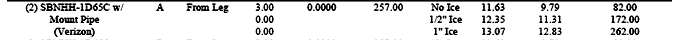

In [186]:
row_crop

In [195]:
allrow[0]

'(2) SBNHH-1D65C w/\nMount Pipe\n(Verizon)\nA\nFrom Leg\n3.00\n0.00\n0.0000\n257.00\nNo Ice\n11.63\n9.79\n82.00\n1/2" Ice\n12.35\n11.31\n172.00\n1" Ice\n13.07\n12.83\n262.00'

In [179]:
for a in allrow:
    for b in range(len(a.split('\n'))):
        if 'From Leg' in a.split('\n')[b]:
         print(a.split('\n')[b])
 


A From Leg
From Leg
From Leg
From Leg
From Leg
RFI America CC807-08-P  B  From Leg  2.00  0.0000  193.00  No Ice  6.90  6.90  27.00
From Leg
From Leg
From Leg
From Leg
From Leg


In [162]:
imgtpocr.size[0]

680

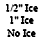

In [ ]:
row_pivotcolum

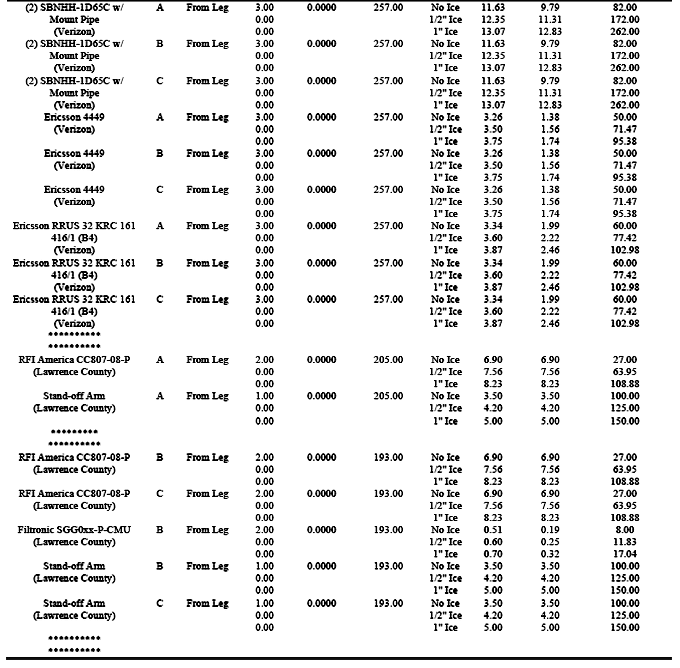

In [ ]:
imgtpocr

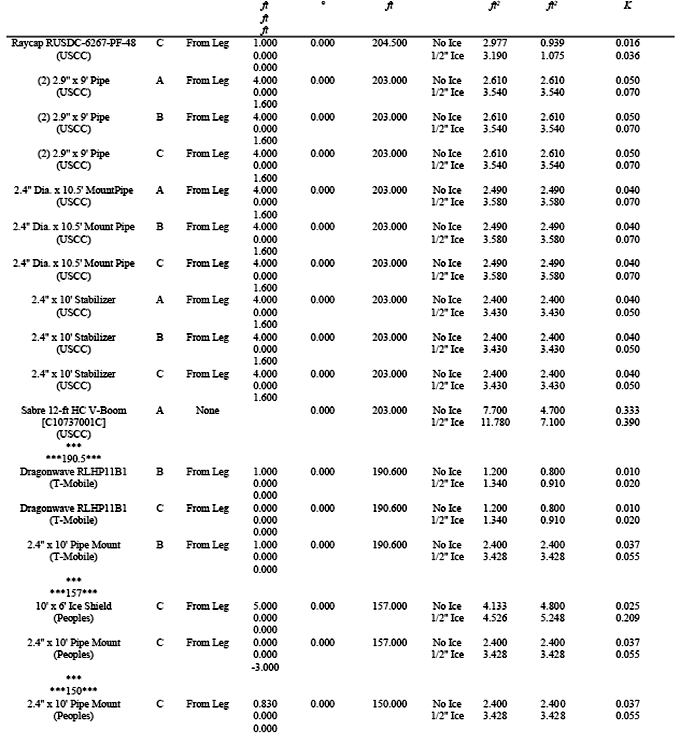

In [ ]:
openimg = Image.open(filepath).convert('RGB')
openimg = scale_width_and_pad_down(openimg)
openimg = openimg.convert('L')
openimg = openimg.crop((0, 59, openimg.width, openimg.height))

enhancer = ImageEnhance.Contrast(openimg)
# openimg = openimg.point(lambda p: 0 if p < 100 else 255)
openimg=openimg.filter(ImageFilter.MedianFilter(size=3))
openimg = enhancer.enhance(1.5)
openimg

In [241]:
listpivot=['Noe,1/2"Ice,1"Ice','No Ice,1/2"Ice,1"Ice','NoIe,1/2"Ice,1"Ice','NoIce,1/2"Ice,1"Ice','1"Ice,Noe,/2"Ice','1"Ice,Noe,1/2"Ice','1"Ice,Noe,1/"Ice','1"Ice,NoIce,1/2"Ice','1"Ice,NoIce,/2"Ice']
for filename in os.listdir(inputimg)[:1]:
    filepath = os.path.join(inputimg, filename)
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    print(f"Procesando: {filename}")
    openimg = Image.open(filepath).convert('RGB')
    openimg = scale_width_and_pad_down(openimg)
    openimg = openimg.convert('L')
    openimg = openimg.crop((0, 59, openimg.width, openimg.height))

    enhancer = ImageEnhance.Contrast(openimg)
    openimg = openimg.point(lambda p: 0 if p < 100 else 255)
    openimg = enhancer.enhance(2)
    openimg=cortar_por_primera_linea_negra(openimg)
    # openimg = openimg.filter(ImageFilter.GaussianBlur(radius=.01))
    openimg=openimg.filter(ImageFilter.MedianFilter(size=1))
    imgtpocr=openimg



    column_boundaries = find_column_boundaries(openimg)
    row_size=13
    row_less=[0,-3,6]
    pivotcolum=imgtpocr.crop((column_boundaries[5][0]-5, 0, column_boundaries[5][1]+15, openimg.height))
    for x in range(1):
         width, height = pivotcolum.size
         n_round=math.floor(height/(row_size+1.5))  
         print(row_less[x])
         for e in range(n_round)[:1]:
             
             top = e * row_size
             bottom = top + row_size
             row_pivotcolum = pivotcolum.crop((0, top+row_less[x], width, bottom+row_less[x]))
             keyword=pytesseract.image_to_string(row_pivotcolum.resize((row_pivotcolum.width * 8, row_pivotcolum.height * 8), Image.LANCZOS), config = r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=No1/2"eIc,').strip().replace('\n',',') 
            #  if keyword in listpivot:
            #       print('keyword search in row less '+ str(row_less))
            #       for i, (x0, x1) in enumerate(column_boundaries[:1]):
            #         if x0+10 < x1 and i==1:
            #          col_crop = imgtpocr.crop((x0-38, 0, x1+15, openimg.height))
            #         elif x0+10 < x1 and i==0:
            #           col_crop = imgtpocr.crop((x0-x0, 0, x1+30, openimg.height))
            #         elif x0+10 < x1:
            #          col_crop = imgtpocr.crop((x0-5, 0, x1+15, openimg.height))
            #         width, height = col_crop.size


            #         row_crop = col_crop.crop((0, top+row_less[x], width, bottom+row_less[x])) 
        #                if i==0:
        #                   element1 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 10, row_crop.height * 10), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng').strip().replace('\n',',')
        #                   e1.append(element1)
        #                elif i==1:
        #                    element2 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=ABCDFromLegNn ').strip()
        #                    e2.append(element2)   
        #                elif i==2:
        #                    element3 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',')  
        #                    e3.append(element3)   
        #                elif i==3:
        #                    element4 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 7 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
        #                    e4.append(element4)      
        #                elif i==4:
        #                    element5 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 7 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
        #                    e5.append(element5)      
        #                elif i==5:
        #                    element6 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS), config = r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=No1/2"eIc,').strip().replace('\n',',')    
        #                    e6.append(element6)   
        #                elif i==6:
        #                    element7 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 5, row_crop.height * 5), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
        #                    e7.append(element7)      
        #                elif i==7: 
        #                    element8 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
        #                    e8.append(element8)   
        #                elif i==8:           
        #                    element9 = pytesseract.image_to_string(row_crop.resize((row_crop.width * 8, row_crop.height * 8), Image.LANCZOS), config=r'--psm 6 --oem 3 -l eng -c tessedit_char_whitelist=0123456789.').strip().replace('\n',',') 
        #                    e9.append(element9) 
        #             print('Spin '+ str(x), 'column '+ str(i), 'page '+ str(filename), 'row less: '+ str(row_less))


Procesando: 1b.PNG
black line search in y = 36 with 15 white pixels.
0


In [245]:
row_pivotcolum

In [189]:
e5

[]

In [193]:
sample=({
  'column1':e1,
  'column2':e2,
  'column3':e3,
  'column4':e4,
  'column5':e5,
  'column6':e6,
  'column7':e7,
  'column8':e8,
  'column9':e9,
})







In [194]:
pre_data=pd.DataFrame(sample)


In [195]:
pre_data

,column1,column2,column3,column4,column5,column6,column7,column8,column9
0,"(2) SBNHH-1D65C w/,Mount Pipe,(Verizon),E","B,From Leg","3.00,0.00,0.00",0.0000,257.00,"No Ice,1/2"" Ice,1"" Ice","11.63,12.35,13.07","9.79,11.31,12.83","82.00,172.00,262.00"
1,"(2) SBNHH-1D65C w/,Mount Pipe,(Verizon)","с,From Leg","3.00,0.00,0.00",0.0000,257.00,"No Ice,1/2"" Ice,1"" Ice","11.63,12.35,13.07","9.79,11.31,12.83","82.00,172.00,262.00"
2,"Ericsson 4449,(Verizon),E","B,From Leg","3.00,0.00,0.00",0.0000,257.00,"ice,No Ice,1/2"" Ice,1"" Ice","5.1,3.26,3.50,375","1.38,1.56,174","50.00,71.47,95 38"
3,"Ericsson 4449,(Verizon)","с,From Leg","3.00,0.00,0.00",0.0000,257.00,"No Ice,1/2"" Ice,1"" Ice","3.26,3.50,3.75","1.38,1.56,1.74","50.00,71.47,95.38"
4,"Ericsson RRUS 32 KRC 161,A,416/1 (B4),(Verizon)","A,From Leg","3.00,0.00,0.00",0.0000,257.00,"No Ice,1/2"" Ice,1"" Ice","3.34,3.60,3.87","1.99,2.22,2.46","60.00,77.42,102.98"
...,...,...,...,...,...,...,...,...,...
258,"Dragonwave RLHP11B1,(T-Mobile)","B,From Leg","1.000,0.000,0.000",0.000,190.600,"No Ice,1/2"" Ice","1.200,1.340","0.800,0.910","0.010,0.020"
259,"Dragonwave RLHP11B1,(T-Mobile)","с,From Leg","0.000,0.000,0.000",0.000,190.600,"No Ice,1/2"" Ice","1.200,1.340","0.800,0.910","0.010,0.020"
260,"10' x 6' Ice Shield,(Peoples)","с,From Leg","5.000,0.000,2000",0.000,157.000,"No Ice,1/2"" Ice","4.133,4.526","4.800,5.248","0.025,0.209"
261,"2.4"" x 10' Pipe Mount,(Peoples)","с,From Leg","0.000,0.000,-3.000",0.000,157.000,"No Ice,1/2"" Ice","2.400,3.428","2.400,3.428","0.037,0.055"


In [196]:
pre_data=pd.DataFrame(sample)


pre_data.drop_duplicates(inplace=True)


pre_data.reset_index(inplace=True)

df=pre_data.index
df = pd.DataFrame(df, columns=['QTY'])  




df['Description']=pre_data['column1']
df['Note/Carrier']=None
df['Note/Carrier']=df['Description'].str.extract(r'\(([a-zA-Z-]+)\)')
df['Face or Leg'] = pre_data['column2'].apply(
    lambda x: x.split(',')[0] if isinstance(x, str) and x.strip() else None
)

df['Offset Type'] = pre_data['column2'].apply(
    lambda x: ' '.join(x.split(',')[1:]) if isinstance(x, str) and x.strip() else None
)

def get_part(x, idx):
    if isinstance(x, str):
        parts = x.split(',')
        if len(parts) > idx:
            return parts[idx].strip()
    return None

df['Horizontal'] = pre_data['column3'].apply(lambda x: get_part(x, 0))
df['Lateral']    = pre_data['column3'].apply(lambda x: get_part(x, 1))
df['Vertical']   = pre_data['column3'].apply(lambda x: get_part(x, 2))
df['Azimuth Adjustment(degree)']= pre_data['column4']
df['Placement(ft)']=pre_data['column5']
def safe_split(x, index):
    if isinstance(x, str):
        parts = x.split(',')
        if len(parts) > index:
            return parts[index].strip()
    return None

df['CaAa Front (No Ice) ft^2']     = pre_data['column7'].apply(lambda x: safe_split(x, 0))
df['CaAa Front (1/2" Ice) ft^2']   = pre_data['column7'].apply(lambda x: safe_split(x, 1))
df['CaAa Side (No Ice) ft^2']=pre_data['column8'].apply(lambda x: safe_split(x, 0))
df['CaAa Side (1/2" Ice) ft^2']=pre_data['column8'].apply(lambda x: safe_split(x, 1))
df['Weight (No Ice) Weight']=pre_data['column9'].apply(lambda x: safe_split(x, 0))
df['Weight (1/2" Ice) Weight']=pre_data['column9'].apply(lambda x: safe_split(x, 1))

In [197]:
for index, e in enumerate(df['Face or Leg']):
    if e in ['From Leg','from Leg','from leg']:
        df['Offset Type'][index]='From Leg'
        df['Face or Leg'][index]=None


In [198]:
df.loc[df['Face or Leg'].notna(), 'Face or Leg'] = df['Face or Leg'].str.upper()

In [199]:
df.to_csv('document_on_text.csv',index=False)
df.to_excel('document_on_text.xlsx',index=False)
df.to_json('document_on_text.json', orient='records', indent=4)

In [200]:
df

,QTY,Description,Note/Carrier,Face or Leg,Offset Type,Horizontal,Lateral,Vertical,Azimuth Adjustment(degree),Placement(ft),CaAa Front (No Ice) ft^2,"CaAa Front (1/2"" Ice) ft^2",CaAa Side (No Ice) ft^2,"CaAa Side (1/2"" Ice) ft^2",Weight (No Ice) Weight,"Weight (1/2"" Ice) Weight"
0,0,"(2) SBNHH-1D65C w/,Mount Pipe,(Verizon),E",Verizon,B,From Leg,3.00,0.00,0.00,0.0000,257.00,11.63,12.35,9.79,11.31,82.00,172.00
1,1,"(2) SBNHH-1D65C w/,Mount Pipe,(Verizon)",Verizon,С,From Leg,3.00,0.00,0.00,0.0000,257.00,11.63,12.35,9.79,11.31,82.00,172.00
2,2,"Ericsson 4449,(Verizon),E",Verizon,B,From Leg,3.00,0.00,0.00,0.0000,257.00,5.1,3.26,1.38,1.56,50.00,71.47
3,3,"Ericsson 4449,(Verizon)",Verizon,С,From Leg,3.00,0.00,0.00,0.0000,257.00,3.26,3.50,1.38,1.56,50.00,71.47
4,4,"Ericsson RRUS 32 KRC 161,A,416/1 (B4),(Verizon)",Verizon,A,From Leg,3.00,0.00,0.00,0.0000,257.00,3.34,3.60,1.99,2.22,60.00,77.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,128,"Dragonwave RLHP11B1,(T-Mobile)",T-Mobile,B,From Leg,1.000,0.000,0.000,0.000,190.600,1.200,1.340,0.800,0.910,0.010,0.020
129,129,"Dragonwave RLHP11B1,(T-Mobile)",T-Mobile,С,From Leg,0.000,0.000,0.000,0.000,190.600,1.200,1.340,0.800,0.910,0.010,0.020
130,130,"10' x 6' Ice Shield,(Peoples)",Peoples,С,From Leg,5.000,0.000,2000,0.000,157.000,4.133,4.526,4.800,5.248,0.025,0.209
131,131,"2.4"" x 10' Pipe Mount,(Peoples)",Peoples,С,From Leg,0.000,0.000,-3.000,0.000,157.000,2.400,3.428,2.400,3.428,0.037,0.055
